# YY1-AID Auxin timecourse Differential Expression Analysis

Analyzing RNAseq expression from  YY1-AID auxin timecourse, 3 biological replicates each


In [1]:
library(DESeq2)
library(tidyverse)
library(RColorBrewer)
library(pheatmap)
library(DEGreport)
library(tximport)
library(ggplot2)
library(ggrepel)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The follow

## Import data

In [5]:
samples <- list.files(path = "quants", full.names = T, pattern="quant$")
files <- file.path(samples, "quant.sf")
names(files) <- str_replace(samples, "quants/", "") %>% 
                 str_replace("_quant", "")

In [6]:
files

4786                         4787 
"quants/4786_quant/quant.sf" "quants/4787_quant/quant.sf" 
                        4788                         4789 
"quants/4788_quant/quant.sf" "quants/4789_quant/quant.sf" 
                        4790                         4791 
"quants/4790_quant/quant.sf" "quants/4791_quant/quant.sf" 
                        4792                         4793 
"quants/4792_quant/quant.sf" "quants/4793_quant/quant.sf" 
                        4794                         4795 
"quants/4794_quant/quant.sf" "quants/4795_quant/quant.sf" 
                        4796                         4797 
"quants/4796_quant/quant.sf" "quants/4797_quant/quant.sf"

In [7]:
# # Load the annotation table 
tx2gene <- read.delim("~/data/ref/gencode.vM34.metadata.MGI.gz", header=FALSE)
names(tx2gene) <- c("tx_id", "symbol", 'MGI')

# tx2gene$tx_id <- sapply(strsplit(tx2gene$tx_id, "\\."), "[", 1)


# # Take a look at it 
tx2gene %>% head

,tx_id,symbol,MGI
,<chr>,<chr>,<chr>
1,ENSMUST00000194081.2,Gm38212,MGI:5611440
2,ENSMUST00000194393.2,Gm7449,MGI:3647895
3,ENSMUST00000185509.2,Gm28283,MGI:5578989
4,ENSMUST00000194605.2,Gm37108,MGI:5610336
5,ENSMUST00000191703.2,Gm37275,MGI:5610503
6,ENSMUST00000191467.2,Gm6679,MGI:3648541


In [8]:
txi <- tximport(files, type="salmon", 
                tx2gene=tx2gene,
                countsFromAbundance="lengthScaledTPM",
               ignoreAfterBar = TRUE)

reading in files with read_tsv

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 


transcripts missing from tx2gene: 1510

summarizing abundance

summarizing counts

summarizing length



In [9]:
txi$counts %>% tail()

,4786,4787,4788,4789,4790,4791,4792,4793,4794,4795,4796,4797
Zxdc,628.4903,644.4787150,852.8505,865.7371,580.523610,754.11831,771.8228,889.7703,601.417680,584.0843,658.1693,818.532
Zyg11a,0.0000,0.9995646,0.0000,0.0000,5.013404,3.99943,0.0000,0.0000,1.990237,0.0000,0.0000,0.000
Zyg11b,1588.8415,1573.3578806,1817.8896,1799.2472,1509.085017,1595.31692,1533.9758,1860.9093,1422.887076,1524.4753,1466.8633,1673.513
Zyx,1785.6360,1798.3957150,1415.5617,1982.3775,2077.576678,2127.41331,1494.6204,2537.6863,1850.783674,1795.2225,1640.0894,1803.738
Zzef1,1865.2732,1899.0236708,2166.6074,2106.3937,1890.969549,1666.45862,1939.1212,1964.1507,1959.759056,1855.8192,1912.8680,2084.563
Zzz3,2174.9458,2688.7171753,2838.5895,2771.6782,2209.433123,2608.70900,2622.6346,2729.9392,2391.312731,2791.4671,2504.9650,2680.536


In [10]:
## Create a sampletable/metadata
meta <- read.delim("meta.csv", header=TRUE, sep=',', row.names='sample')

meta

,timepoint,replicate
,<chr>,<chr>
4786,0h,rep1
4787,4h,rep1
4788,24h,rep1
4789,48h,rep1
4790,0h,rep2
4791,4h,rep2
4792,24h,rep2
4793,48h,rep2
4794,0h,rep3


## Generate normalized counts
note - normalized counts shouldnt be used for DESeq2 step

In [11]:
### Check that sample names match in both files
all(colnames(txi$counts) %in% rownames(meta))
all(colnames(txi$counts) == rownames(meta))

[1] TRUE

[1] TRUE

In [12]:
# create deseq2 object
dds <- DESeqDataSetFromTximport(txi, colData = meta, design = ~ timepoint)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
using just counts from tximport



In [13]:
dds <- estimateSizeFactors(dds)

In [14]:
normalized_counts <- counts(dds, normalized=TRUE)
write.table(normalized_counts, file="./normalized_counts.txt", sep="\t", quote=F, col.names=NA)


## QC

In [15]:
### Transform counts for data visualization
rld <- rlog(dds, blind=TRUE)

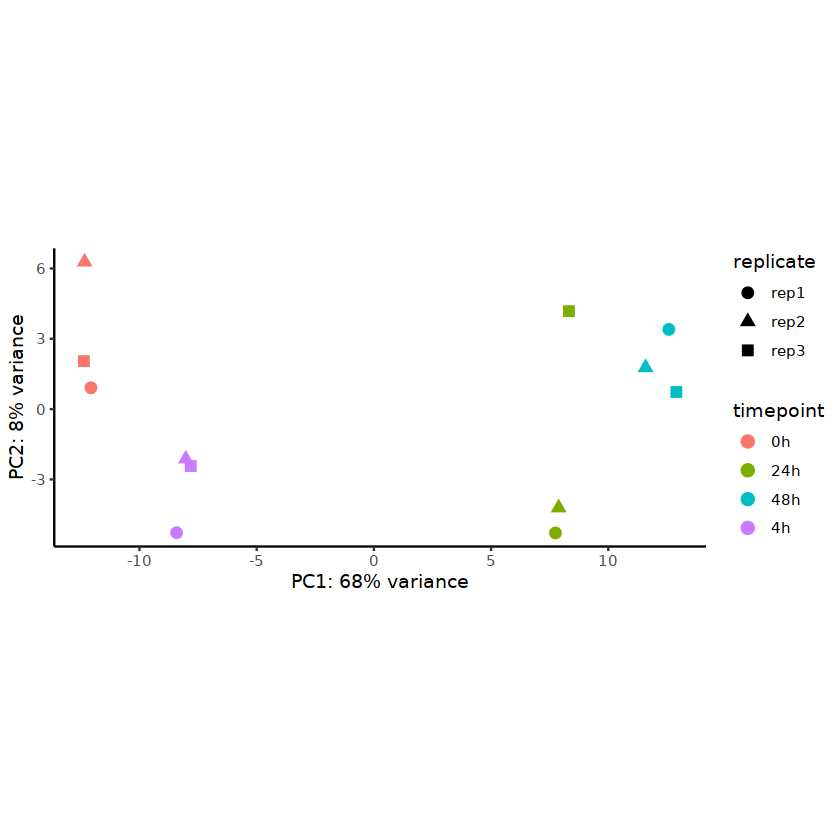

In [16]:
### Plot PCA  - SAVE
# pdf(file="PCA_normalized_rlogtransform.pdf")

pcaData <- plotPCA(rld, intgroup=c("timepoint", "replicate"), returnData=TRUE)
percentVar <- round(100 * attr(pcaData, "percentVar"))
ggplot(pcaData, aes(PC1, PC2, color=timepoint, shape=replicate)) +
  geom_point(size=3) +
  xlab(paste0("PC1: ",percentVar[1],"% variance")) +
  ylab(paste0("PC2: ",percentVar[2],"% variance")) + 
  coord_fixed() + 
  theme_classic()

# dev.off()

In [17]:
### Extract the rlog matrix from the object
rld_mat <- assay(rld)   

### Compute pairwise correlation values
rld_cor <- cor(rld_mat)    ## cor() is a base R function

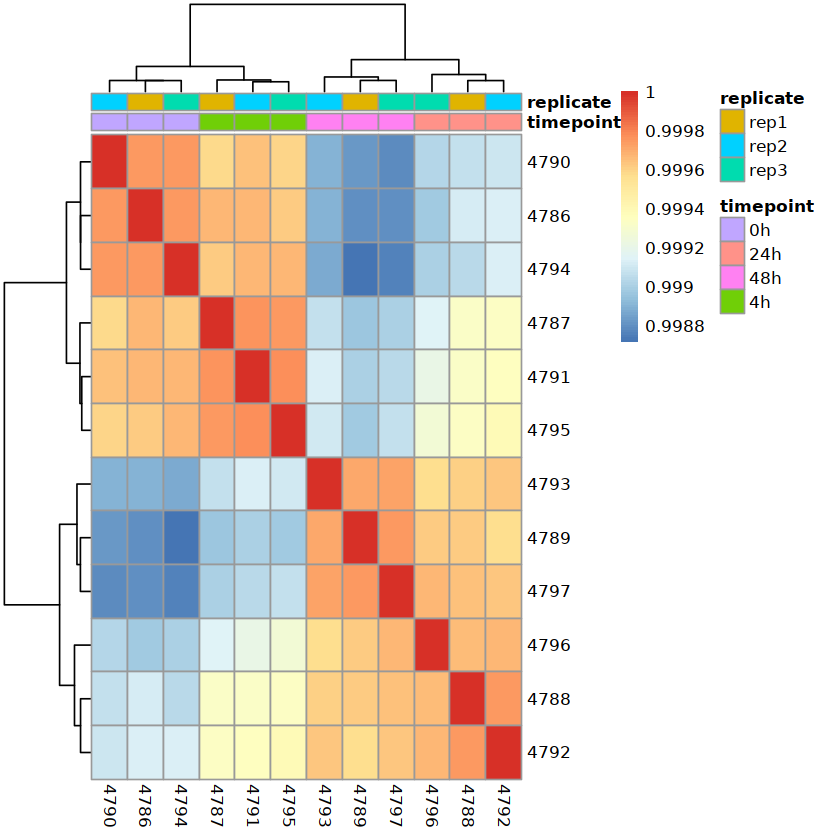

In [18]:
# save plot
# pdf("heatmap_sampleclusters.pdf")
pheatmap(rld_cor, annotation = meta)
# dev.off()

## Run DESeq

In [19]:
dds <- DESeqDataSetFromTximport(txi, colData = meta, design = ~ timepoint)
dds <- DESeq(dds)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
using just counts from tximport

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



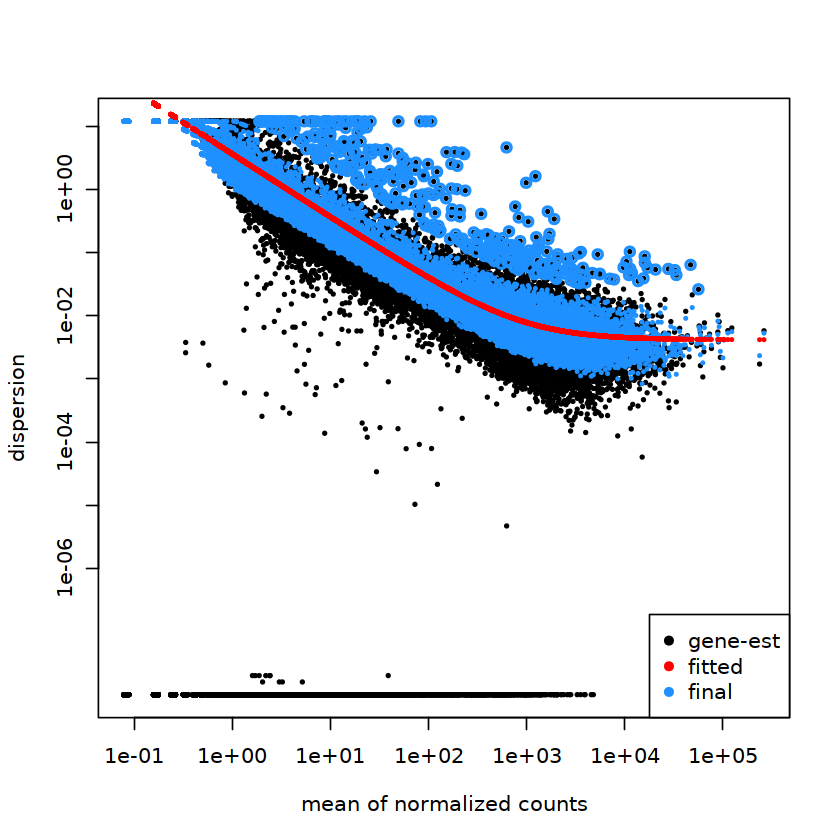

In [20]:
## Plot dispersion estimates
# pdf("dispersion.pdf")

plotDispEsts(dds)
# dev.off()

In [21]:
paste(meta$replicate,meta$timepoint, sep="_")

[1] "rep1_0h"  "rep1_4h"  "rep1_24h" "rep1_48h" "rep2_0h"  "rep2_4h" 
 [7] "rep2_24h" "rep2_48h" "rep3_0h"  "rep3_4h"  "rep3_24h" "rep3_48h"

In [22]:
tmp <- counts(dds, normalized=FALSE)
colnames(tmp) <- paste(meta$replicate,meta$timepoint, sep="_")
write.table(tmp, file="~/RNAseq_YY1aid_timeseries_raw_counts.txt", sep="\t", quote=F)


# Hypothesis testing

In [23]:
resultsNames(dds)

[1] "Intercept"           "timepoint_24h_vs_0h" "timepoint_48h_vs_0h"
[4] "timepoint_4h_vs_0h"

## 4h vs WT (0h)

In [24]:
# fold change represented as log2 fold over WT
# alpha set to FDR value, default multiple test correction = bh
# lfcthreshold - p value corresponds to test for 0 log fold change by default
res <- results(dds, contrast=c("timepoint","4h","0h"), 
               lfcThreshold = 0,
              alpha = 0.05, pAdjustMethod="BH")

# shrink lfc values for downstream analysis
res <- lfcShrink(dds, res=res, coef='timepoint_4h_vs_0h')

summary(res, alpha=0.05)

# Create a tibble of results
res_tb <- res %>%
  data.frame() %>%
  rownames_to_column(var="symbol") %>% 
  as_tibble()

write.table(res_tb, "deseq_timepoint_4h_vs_0h.csv", sep=",", row.names=F)

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895




out of 30599 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 642, 2.1%
LFC < 0 (down)     : 1028, 3.4%
outliers [1]       : 18, 0.059%
low counts [2]     : 18164, 59%
(mean count < 20)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



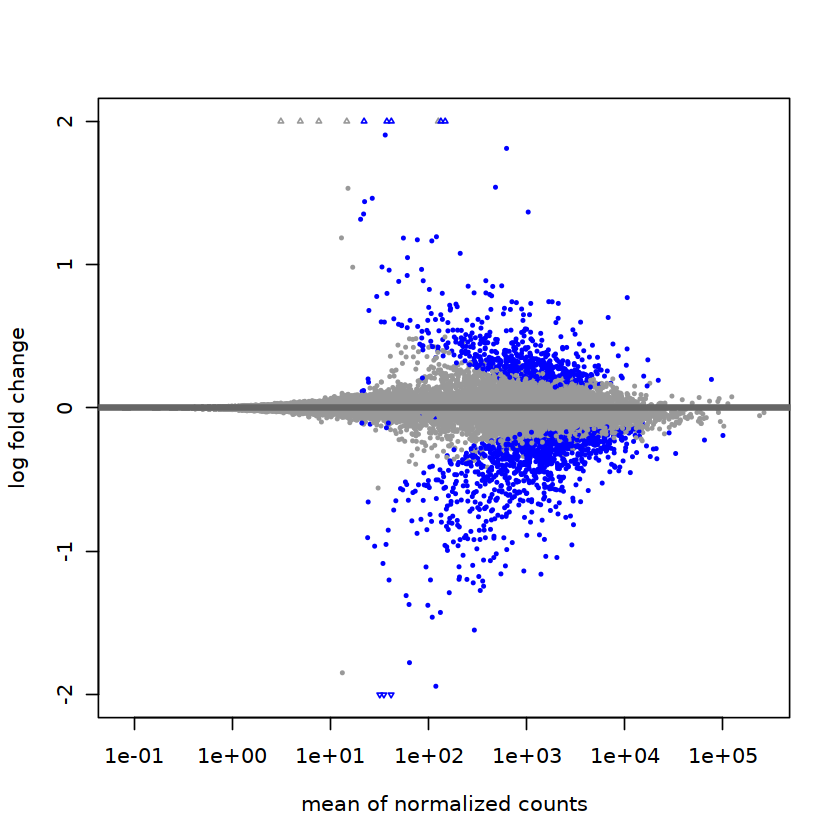

In [25]:
# pdf("MAplot_timepoint_4h_vs_0h.pdf")
plotMA(res, ylim=c(-2,2))
# dev.off()

In [26]:
## Obtain logical vector where TRUE values denote padj values < 0.05 and fold change > 1.5 in either direction
res_tb <- res_tb %>% 
                  mutate(threshold_OE = padj < 0.05 & abs(log2FoldChange) >= 0.58)

In [27]:

## Create an empty column to indicate which genes to label
res_tb <- res_tb %>% mutate(genelabels = "")

## Sort by padj values 
res_tb <- res_tb %>% arrange(padj)

## Populate the genelabels column with contents of the gene symbols column for the first 10 rows, i.e. the top 10 most significantly expressed genes
res_tb$genelabels[1:10] <- as.character(res_tb$symbol[1:10])

## 24h vs WT (0h)

In [29]:
# fold change represented as log2 fold over WT
# alpha set to FDR value, default multiple test correction = bh
# lfcthreshold - p value corresponds to test for 0 log fold change by default
res <- results(dds, contrast=c("timepoint","24h","0h"), 
               lfcThreshold = 0,
              alpha = 0.05, pAdjustMethod="BH")

# shrink lfc values for downstream analysis
res <- lfcShrink(dds, res=res, coef='timepoint_24h_vs_0h')

summary(res, alpha=0.05)

# Create a tibble of results
res_tb <- res %>%
  data.frame() %>%
  rownames_to_column(var="symbol") %>% 
  as_tibble()

write.table(res_tb, "deseq_timepoint_24h_vs_0h.csv", sep=",", row.names=F)

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895




out of 30599 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 2947, 9.6%
LFC < 0 (down)     : 3426, 11%
outliers [1]       : 18, 0.059%
low counts [2]     : 12496, 41%
(mean count < 3)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



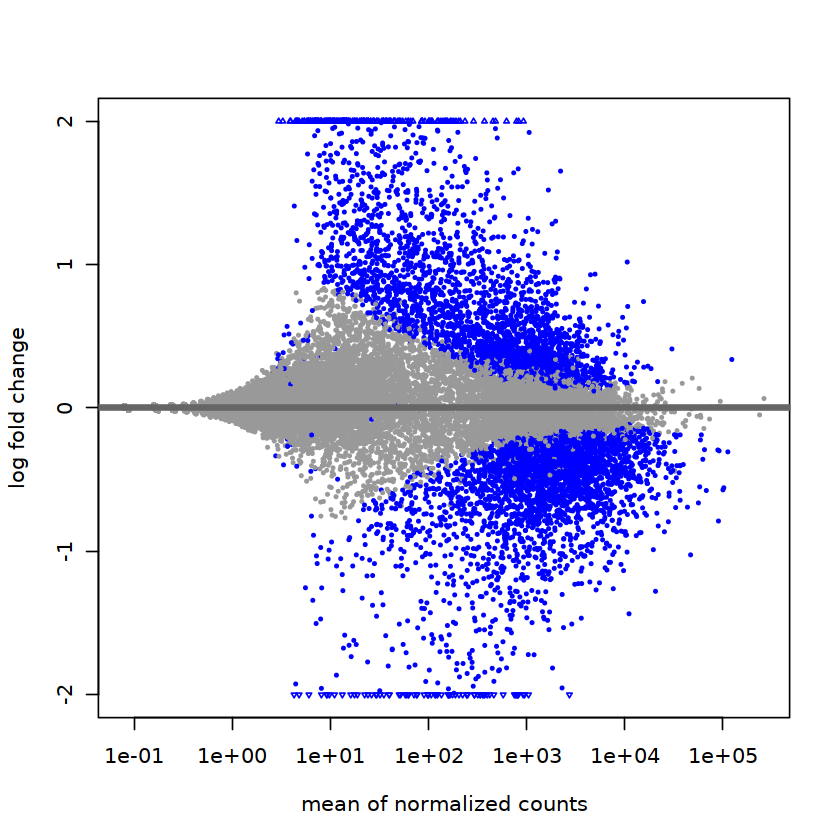

In [30]:
# pdf("MAplot_timepoint_24h_vs_0h.pdf")
plotMA(res, ylim=c(-2,2))
# dev.off()

## 48h vs WT (0h)


In [31]:
# fold change represented as log2 fold over WT
# alpha set to FDR value, default multiple test correction = bh
# lfcthreshold - p value corresponds to test for 0 log fold change by default
res <- results(dds, contrast=c("timepoint","48h","0h"), 
               lfcThreshold = 0,
              alpha = 0.05, pAdjustMethod="BH")

# shrink lfc values for downstream analysis
res <- lfcShrink(dds, res=res, coef='timepoint_48h_vs_0h')

summary(res, alpha=0.05)

# Create a tibble of results
res_tb <- res %>%
  data.frame() %>%
  rownames_to_column(var="symbol") %>% 
  as_tibble()

write.table(res_tb, "deseq_timepoint_48h_vs_0h.csv", sep=",", row.names=F)

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895




out of 30599 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 3565, 12%
LFC < 0 (down)     : 3811, 12%
outliers [1]       : 18, 0.059%
low counts [2]     : 12496, 41%
(mean count < 3)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



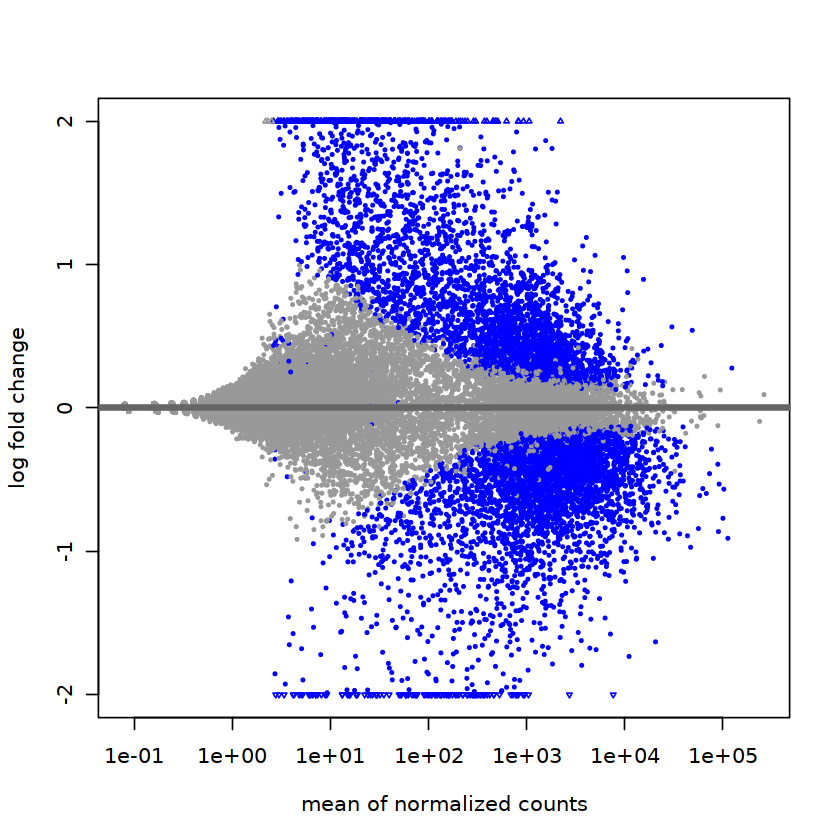

In [32]:
# pdf("MAplot_timepoint_48h_vs_0h.pdf")
plotMA(res, ylim=c(-2,2))
# dev.off()

In [33]:
sessionInfo()

R version 4.1.0 (2021-05-18)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux 9.1 (Plow)

Matrix products: default
BLAS/LAPACK: /home/lamj2/miniconda3/envs/Renv/lib/libopenblasp-r0.3.15.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] ggrepel_0.9.5               tximport_1.20.0            
 [3] DEGreport_1.28.0            pheatmap_1.0.12            
 [5] RColorBrewer_1.1-2          forcats_0.5.1              
 [7] stringr_1.5.1               dplyr_1.1.4                
 [9] purrr_1.0.2      